# **Studants Exam Performance - Regressão Logística**

## Objetivos

## Importação das bibliotecas

In [126]:
%matplotlib inline
import os
from sklearn.datasets import load_iris
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F

from IPython import display
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report


import kagglehub
from kagglehub import KaggleDatasetAdapter

## Dataset: Leitura, normalização e visualização dos dados

In [127]:
dataset = "mrsimple07/student-exam-performance-prediction"
file_path = "student_exam_data.csv"

df = kagglehub.load_dataset(
    KaggleDatasetAdapter.PANDAS,
    dataset,
    file_path
)
df.head(5)

/tmp/ipython-input-4110259591.py:4: DeprecationWarning: Use dataset_load() instead of load_dataset(). load_dataset() will be removed in a future version.
  df = kagglehub.load_dataset(


Using Colab cache for faster access to the 'student-exam-performance-prediction' dataset.


,Study Hours,Previous Exam Score,Pass/Fail
0,4.370861,81.889703,0
1,9.556429,72.165782,1
2,7.587945,58.571657,0
3,6.387926,88.827701,1
4,2.404168,81.083870,0


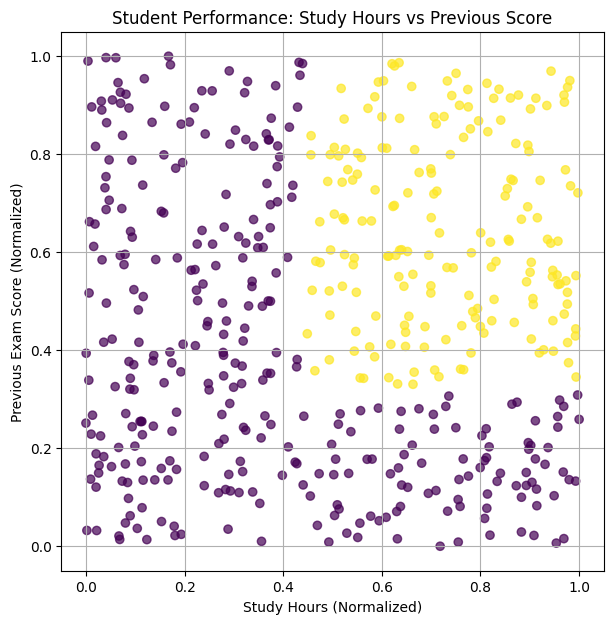

In [128]:
# X: Seleção de features (Study Hours e Previous Exam Score)
X = df[['Study Hours', 'Previous Exam Score']]

# Normalização (Min-Max Scaling)
Xc_aux = X - X.min(axis=0)
Xs = X.max(axis=0) - X.min(axis=0)
# Proteção contra divisão por zero
Xs[Xs == 0] = 1.0
Xc_aux2 = Xc_aux / Xs

# Y: Variável alvo
Y = df['Pass/Fail'].values # Assumindo que Y é numérico (0 ou 1, por exemplo)


# Converte o DataFrame normalizado para um array NumPy para usar a indexação de posição ([:, 0])
Xc = Xc_aux2.values

plt.figure(figsize=(7, 7))

plt.scatter(Xc[:, 0], Xc[:, 1], c=Y, alpha=0.7) # Adicionado c=Y para colorir
plt.xlabel('Study Hours (Normalized)')
plt.ylabel('Previous Exam Score (Normalized)')
plt.title('Student Performance: Study Hours vs Previous Score')
plt.grid(True)
plt.show()

# Dividindo Dataset em Treinamento E Validação

In [129]:
x_train, x_test, y_train, y_test = train_test_split(Xc, Y, test_size=0.2, random_state=42)

In [130]:
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(400, 2)
(100, 2)
(400,)
(100,)


### Prepara os dados para o PyTorch

In [131]:
X_train_tensor = torch.FloatTensor(x_train)  # Entrada é FloatTensor
Y_train_tensor = torch.LongTensor(y_train)    # Classe é LongTensor
X_test_tensor = torch.FloatTensor(x_test)  # Entrada é FloatTensor
Y_test_tensor = torch.LongTensor(y_test)    # Classe é LongTensor

In [132]:
Y_train_tensor

tensor([1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1,
        1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0,
        0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1,
        1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1,
        0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0,
        0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0,
        0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0,
        0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0,
        0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0,
        0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1,
        1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
        1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0,
        0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0,

In [133]:
X_train_tensor

tensor([[0.8583, 0.6227],
        [0.0972, 0.5236],
        [0.2897, 0.1465],
        [0.6632, 0.3305],
        [0.0094, 0.1369],
        [0.0845, 0.1300],
        [0.5327, 0.1486],
        [0.6337, 0.1598],
        [0.7620, 0.4500],
        [0.1162, 0.5095],
        [0.7065, 0.2390],
        [0.4954, 0.7992],
        [0.0361, 0.4163],
        [0.7897, 0.4664],
        [0.9688, 0.2855],
        [0.3370, 0.5407],
        [0.9734, 0.5416],
        [0.0195, 0.8160],
        [0.1837, 0.2736],
        [0.0297, 0.2251],
        [0.6605, 0.9383],
        [0.6943, 0.1079],
        [0.5508, 0.8022],
        [0.4903, 0.7445],
        [0.5037, 0.8139],
        [0.3928, 0.7945],
        [0.3276, 0.9485],
        [0.9044, 0.1304],
        [0.8229, 0.4602],
        [0.2456, 0.4498],
        [0.1675, 1.0000],
        [0.8129, 0.0775],
        [0.0072, 0.6623],
        [0.8149, 0.8460],
        [0.9691, 0.0155],
        [0.1933, 0.0243],
        [0.9063, 0.5055],
        [0.4565, 0.8378],
        [0.5

## Construindo o modelo da rede

A saída da rede é composta por um neurônio para cada classe. A saída é denominada *scores* ou logitos:

![alt text](https://raw.githubusercontent.com/vcasadei/images/master/RegressaoLogisticaRede_2_3.png)

In [134]:
model = nn.Linear(2,3)  # 2 entradas e 3 saídas

In [135]:
model.state_dict()

OrderedDict([('weight',
              tensor([[ 0.0463, -0.4297],
                      [ 0.4948,  0.3504],
                      [ 0.6212,  0.3409]])),
             ('bias', tensor([0.5147, 0.2580, 0.5457]))])

### Fazendo um predict

In [136]:
out = model(X_train_tensor[:4,:]) # 4 amostras
out

tensor([[0.2869, 0.9009, 1.2912],
        [0.2942, 0.4897, 0.7847],
        [0.4652, 0.4527, 0.7756],
        [0.4034, 0.7020, 1.0704]], grad_fn=<AddmmBackward0>)

In [137]:
oo = F.softmax(out,dim=1)
oo

tensor([[0.1793, 0.3313, 0.4894],
        [0.2598, 0.3159, 0.4243],
        [0.2984, 0.2947, 0.4070],
        [0.2328, 0.3137, 0.4535]], grad_fn=<SoftmaxBackward0>)

### Calculando as probabilidades com Softmax

- [Wikipedia:Softmax_function](https://en.wikipedia.org/wiki/Softmax_function)

![alt text](https://raw.githubusercontent.com/vcasadei/images/master/softmax.png)

In [138]:
F.softmax(out,dim=1)*100

tensor([[17.9276, 33.1287, 48.9437],
        [25.9809, 31.5900, 42.4291],
        [29.8356, 29.4667, 40.6978],
        [23.2760, 31.3750, 45.3490]], grad_fn=<MulBackward0>)

### Predição da classe

In [139]:
prob,y_pred = torch.max(F.softmax(out,dim=1),dim=1)
print(y_pred)
print(prob)

tensor([2, 2, 2, 2])
tensor([0.4894, 0.4243, 0.4070, 0.4535], grad_fn=<MaxBackward0>)


## Treinamento

### Classe para visualização dinâmica

In [140]:
def predict(model, inputs):
    outputs = model(Variable(inputs))
    _, predicts = torch.max(outputs, 1)

    return predicts.data.numpy()

def predict_prob(model, inputs):
    outputs = model(Variable(inputs))
    outputs = F.softmax(outputs,dim=1)
    predicts, _ = torch.max(outputs, 1)

    return predicts.data.numpy()

class MyPlotter():
    def __init__(self, model, X, Y, n_epoch, filepath=None, h = .01):
        self.model = model
        self.X = X
        self.Y = Y
        self.n_epoch = n_epoch
        self.filepath = filepath
        x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
        y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
        self.xx, self.yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
        self.loss_hist = []
        self.val_loss_hist = []
        self.X_grid = np.c_[self.xx.ravel(), self.yy.ravel()]

        #Gráficos a serem mostrados pelo callback
        self.fig = plt.figure(figsize=(12, 4), dpi=100)
        self.ax1 = self.fig.add_subplot(1, 3, 1)
        self.ax1.set_xlim(0, nb_epoch)
        self.ax1.set_xlabel('Epoca')#,fontsize=28)
        self.ax1.set_ylabel('Perda')#,fontsize=28)
        self.ax1.set_title('Perda x Época')
        self.ax1.plot([],[],'b',linewidth = 2.0,label = "Treino")
        self.ax1.grid(True)

        self.ax2 = self.fig.add_subplot(1, 3, 2)
        self.ax2.set_xlim(Xc[:,0].min(), Xc[:,0].max())
        self.ax2.set_ylim(Xc[:,1].min(), Xc[:,1].max())
        self.ax2.set_xlabel('Comprimento da Sepala')#,fontsize=28)
        self.ax2.set_ylabel('Largura da Sepala')#,fontsize=28)
        self.ax2.set_title('Fronteiras de decisão')

        self.ax3 = self.fig.add_subplot(1, 3, 3)
        self.ax3.set_xlim(Xc[:,0].min(), Xc[:,0].max())
        self.ax3.set_ylim(Xc[:,1].min(), Xc[:,1].max())
        self.ax3.set_xlabel('Comprimento da Sepala')#,fontsize=28)
        self.ax3.set_ylabel('Largura da Sepala')#,fontsize=28)
        self.ax3.set_title('Máxima probabilidade')

    def on_train_begin(self, logs={}):
        display.display(self.fig)
        display.clear_output(wait=True)

    def on_epoch_end(self, epoch, logs={}):
        if 'loss' in logs.keys():
            self.loss_hist.append(logs['loss'])

            if epoch%250==0:
                self.ax1.plot(np.arange(epoch+1), self.loss_hist, 'b', linewidth = 2.0)

                #Z = predict(self.model, torch.from_numpy(self.X_grid).type(torch.FloatTensor))
                Zc = predict(self.model,torch.FloatTensor(self.X_grid))
                Zc = Zc.reshape(self.xx.shape)

                self.ax2.pcolormesh(self.xx, self.yy, Zc, cmap=plt.cm.Paired)
                colors = np.array(['r','y','b'])
                self.ax2.scatter(self.X[:, 0], self.X[:, 1], s=40, c=colors[self.Y], edgecolors='k', cmap=plt.cm.Paired)

                Zp = predict_prob(self.model,torch.FloatTensor(self.X_grid))
                Zp = Zp.reshape(self.xx.shape)

                self.ax3.pcolormesh(self.xx, self.yy, Zp, cmap=plt.cm.magma)
                colors = np.array(['r','y','b'])
                self.ax3.scatter(self.X[:, 0], self.X[:, 1], s=40, c=colors[self.Y], edgecolors='k', cmap=plt.cm.Paired)

                display.display(self.fig)
                display.clear_output(wait=True)

### Laço principal de treinamento da Regressão Logística por Softmax

In [141]:
lr = 0.15

optimizer = torch.optim.SGD(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

In [142]:
nb_epoch = 10000

losses = []
losses_test = []
acc_list = []
acc_test_list = []
for i in range(nb_epoch):
    # predict da rede
    output = model(X_train_tensor)
    output_test = model(X_test_tensor)

    # calcula a perda
    loss = criterion(output, Y_train_tensor)
    loss_test = criterion(output_test, Y_test_tensor)

    # Faz o backpropagation para calcular os gradientes e otimizar parâmetros
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    losses.append(loss.data.item())
    losses_test.append(loss_test.data.item())

    _, class_max = torch.max(F.softmax(output,dim=1),dim=1)
    _, class_test_max = torch.max(F.softmax(output_test,dim=1),dim=1)
    acc_list.append((class_max == Y_train_tensor).float().mean())
    acc_test_list.append((class_test_max == Y_test_tensor).float().mean())

    final_loss = loss.data.item()

print('Final loss:', final_loss)

Final loss: 0.2558724582195282


In [143]:
print(acc_list)

[tensor(0.), tensor(0.0150), tensor(0.0850), tensor(0.4900), tensor(0.6950), tensor(0.7600), tensor(0.8125), tensor(0.8175), tensor(0.8275), tensor(0.8400), tensor(0.8375), tensor(0.8300), tensor(0.8250), tensor(0.8250), tensor(0.8275), tensor(0.8100), tensor(0.7925), tensor(0.7900), tensor(0.7850), tensor(0.7800), tensor(0.7625), tensor(0.7625), tensor(0.7625), tensor(0.7625), tensor(0.7600), tensor(0.7600), tensor(0.7625), tensor(0.7625), tensor(0.7625), tensor(0.7625), tensor(0.7625), tensor(0.7625), tensor(0.7650), tensor(0.7675), tensor(0.7675), tensor(0.7700), tensor(0.7775), tensor(0.7875), tensor(0.7875), tensor(0.7875), tensor(0.7875), tensor(0.7900), tensor(0.7925), tensor(0.7925), tensor(0.7950), tensor(0.7975), tensor(0.7975), tensor(0.8025), tensor(0.8025), tensor(0.8050), tensor(0.8050), tensor(0.8100), tensor(0.8125), tensor(0.8125), tensor(0.8125), tensor(0.8175), tensor(0.8150), tensor(0.8150), tensor(0.8150), tensor(0.8150), tensor(0.8150), tensor(0.8150), tensor(0.81

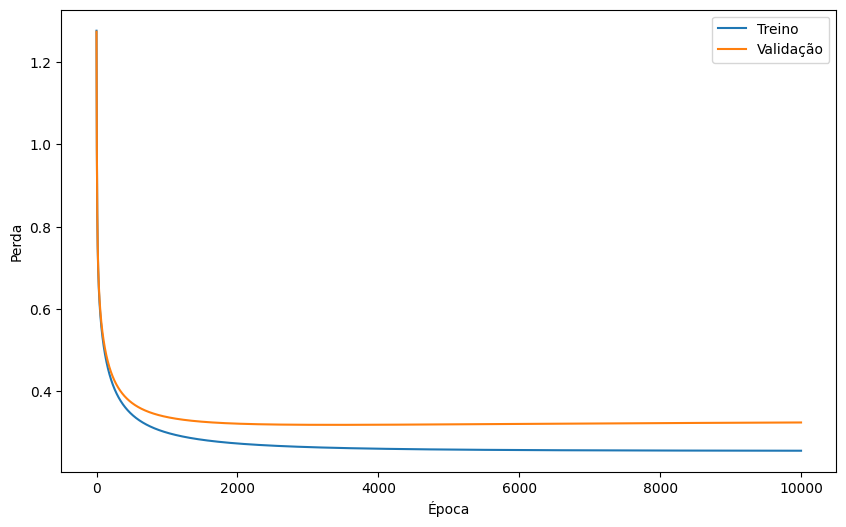

In [144]:
plt.figure(figsize=(10, 6))
plt.plot(list(range(nb_epoch)), losses, label='Treino')
plt.plot(list(range(nb_epoch)), losses_test, label='Validação')
plt.xlabel('Época')
plt.ylabel('Perda')
plt.legend()
plt.show()

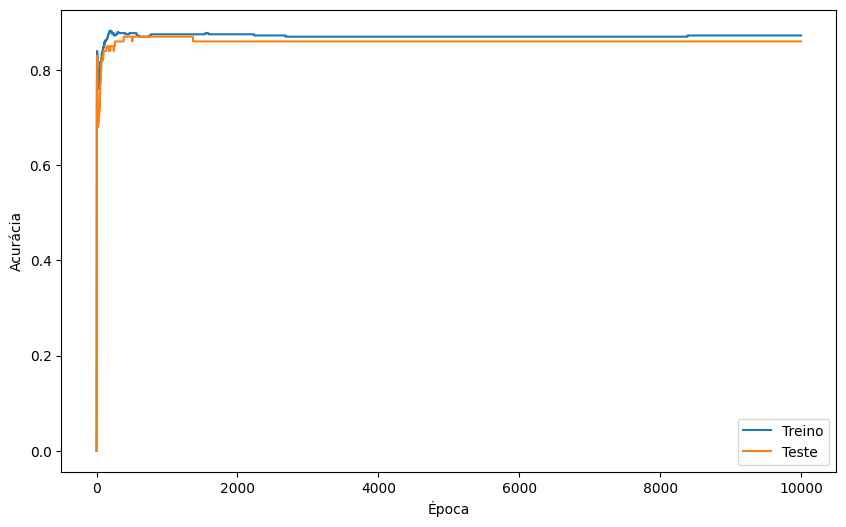

In [145]:
plt.figure(figsize=(10, 6))
plt.plot(list(range(nb_epoch)), acc_list, label='Treino')
plt.plot(list(range(nb_epoch)), acc_test_list, label='Teste')
plt.xlabel('Época')
plt.ylabel('Acurácia')
plt.legend()
plt.show()

# **Conclusão**

O modelo de Regressão Logística para a base "Student Exam Performance" com as variáveis de entrada (Study Hours, Previous Exam Score) e a variável de saída (Pass/Fail - com 3 classes) apresenta um desempenho excelente.

- Modelo Robusto: O modelo convergiu de forma eficiente e se estabilizou em um alto nível de desempenho.

- Boa Generalização: A similaridade entre as métricas de Treino e Teste/Validação demonstra que o modelo não está sobreajustado e é capaz de fazer previsões precisas em dados novos.

O treinamento poderia ter sido interrompido muito mais cedo (por volta das 2000 a 4000 épocas) sem perda significativa de desempenho, economizando tempo de processamento.